<a href="https://colab.research.google.com/github/chimaOkwuokei/machine-learning-projects/blob/main/ISEND_assignment_using_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT** **LIBRARIES**

In [ ]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import numpy as np

import requests
from PIL import Image
from io import BytesIO

In [ ]:
numb_batch = 64

# **GETTING DATA**

In [ ]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


train_data = torchvision.datasets.MNIST('mnist_data',train=True,download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data',train=False,download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size=numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=numb_batch)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34653270.06it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1236595.86it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10451654.89it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5658012.70it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



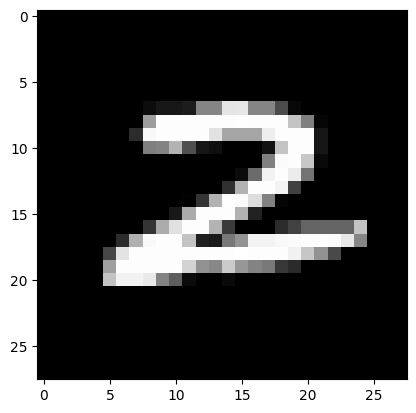

In [ ]:
plt.imshow(train_data[199][0][0], cmap="gray")

# **CREATE MODEL**

In [ ]:
def create_lenet():
  model = nn.Sequential(

      #first conv layer
      nn.Conv2d(1,6,5,padding=2),
      nn.ReLU(), #if < 0, the value would end up being 0
      #pooling for the first conv
      nn.AvgPool2d(2, stride=2),#stride, how many steps it moves to the right
      #this pooling layer gets the average of all the values in the matrix


      #second conv layer
      nn.Conv2d(6,16,5,padding=0),
      nn.ReLU(),
      #pooling for the second conv
      nn.AvgPool2d(2, stride=2),

      #16 * 5 * 5 = 400
      #takes the matrices and flattens them out
      nn.Flatten(),
      nn.Linear(400, 120),
      nn.Linear(120,84),
      nn.Linear(84, 10) #final layer
      #10 is the number of outputs
  )
  return model

# **Validate Model**

In [ ]:
def validate(model,data):
  total = 0
  correct = 0

  for i, (images, labels) in enumerate(data):
    images = images.cuda()
    x = model(images)
    value, pred = torch.max(x,1)
    pred = pred.data.cpu()
    total += x.size(0)
    correct += torch.sum(pred == labels)


  return correct*100./total

# **Training Function**

In [ ]:
def train(numb_epoch=3, lr=1e-3, device="cuda:0"):
  accuracies = []
  cnn = create_lenet().to(device)#making use of the created model function
  cec = nn.CrossEntropyLoss()
  optimizer = optim.Adam(cnn.parameters(), lr=lr)
  max_accuracy = 0

  for epoch in range(numb_epoch):
    for i, (images, labels) in enumerate(train_dl): #loops through the images in train_dl
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()

      #cnn is the model
      pred = cnn(images)
      loss = cec(pred, labels)#gets the loss

      loss.backward()
      optimizer.step()
    accuracy = float(validate(cnn,val_dl))#calls the validation function
    accuracies.append(accuracy)
    if accuracy > max_accuracy:
      best_model = copy.deepcopy(cnn)
      max_accuracy = accuracy
      print("Saving best model with Accuracy: ", accuracy)
    print("Epoch: ", epoch+1,"Accuracy: ", accuracy, "%")
  plt.plot(accuracies)
  return best_model


# **GPU Availability**

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

In [ ]:
device

device(type='cuda', index=0)

# **TRAINING THE MODEL**

Saving best model with Accuracy:  96.75
Epoch:  1 Accuracy:  96.75 %
Saving best model with Accuracy:  97.8499984741211
Epoch:  2 Accuracy:  97.8499984741211 %
Saving best model with Accuracy:  98.20999908447266
Epoch:  3 Accuracy:  98.20999908447266 %
Saving best model with Accuracy:  98.38999938964844
Epoch:  4 Accuracy:  98.38999938964844 %
Saving best model with Accuracy:  98.58999633789062
Epoch:  5 Accuracy:  98.58999633789062 %
Saving best model with Accuracy:  98.66999816894531
Epoch:  6 Accuracy:  98.66999816894531 %
Saving best model with Accuracy:  98.87000274658203
Epoch:  7 Accuracy:  98.87000274658203 %
Epoch:  8 Accuracy:  98.86000061035156 %
Saving best model with Accuracy:  98.9000015258789
Epoch:  9 Accuracy:  98.9000015258789 %
Epoch:  10 Accuracy:  98.7699966430664 %
Saving best model with Accuracy:  98.95999908447266
Epoch:  11 Accuracy:  98.95999908447266 %
Saving best model with Accuracy:  98.9800033569336
Epoch:  12 Accuracy:  98.9800033569336 %
Epoch:  13 Accur

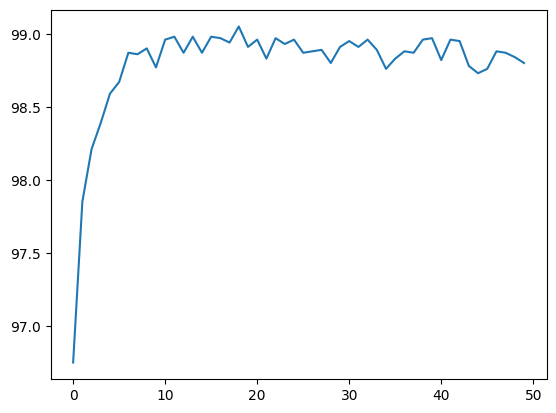

In [ ]:
lenet = train(50, device=device)

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def predict_dl(model, data):
  y_pred = []
  y_true = []
  for i, (images, labels) in enumerate(data):
    images = images.cuda()
    x = model(images)
    value, pred = torch.max(x, 1)
    pred = pred.data.cpu()
    y_pred.extend(list(pred.numpy()))
    y_true.extend(list(labels.numpy()))
  return np.array(y_pred), np.array(y_true)

In [ ]:
y_pred, y_true = predict_dl(lenet, val_dl)#predicts against the validation set

In [ ]:
pd.DataFrame(confusion_matrix(y_true, y_pred,labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,977,0,0,0,0,0,1,0,2,0
1,0,1132,1,1,1,0,0,0,0,0
2,1,1,1028,0,0,0,0,1,1,0
3,0,1,1,1001,0,5,0,0,1,1
4,0,0,1,0,969,0,1,0,0,11
5,1,0,0,5,0,883,1,0,0,2
6,3,2,0,0,1,1,948,0,3,0
7,0,2,6,0,1,0,0,1015,1,3
8,4,0,3,3,0,3,2,0,957,2
9,0,0,0,0,5,6,0,2,1,995


# **DEFINE INFERENCE**

In [ ]:
def inference(path, model, device):

  img = Image.open(path).convert(mode="L")
  img = img.resize((28,28))
  x = (255 - np.expand_dims(np.array(img), -1))/255.
  plt.imshow(x.squeeze(-1), cmap="gray")
  with torch.no_grad():
    pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
    return F.softmax(pred, dim = -1).cpu().numpy()

Predicted: 4, Prob: 0.9828246831893921


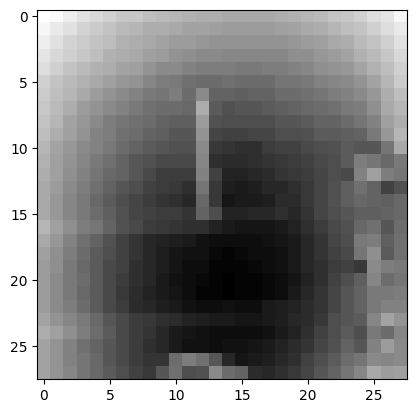

In [ ]:
pred = inference("/content/1.jpeg",lenet,device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]}")

NameError: name 'x' is not defined